## US National Census (Income)

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

### Preprocessing

In [46]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore') 

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from scipy.stats import kstest

%run utils.py

path = Path(os.getcwd()).parent

columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

train = pd.read_csv(os.path.join(path, 'data/census_income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/census_income/adult.test'), names=columns)
test = test.iloc[1:] # drop first row from test set

df = pd.concat([train, test])

In [47]:
df.replace(' >50K.', ' >50K', inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)

df.dropna()
df.reset_index()

ctg = ['Workclass', 'Sex', 'Education', 'Marital Status', 
       'Occupation', 'Relationship', 'Race', 'Country'] # Categorical to Numerical

for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

df_high = df[df['Above/Below 50K'] == " >50K"].copy(deep=True)
df_low = df[df['Above/Below 50K'] == " <=50K"].copy(deep=True)

### Experiment

In [48]:
# Randomize data
df_low = df_low.reindex(np.random.permutation(df_low.index))
df_high = df_high.reindex(np.random.permutation(df_high.index))

rep = df.copy(deep=True)
non_rep = pd.concat([df_low.head(21000).copy(deep=True),
                     df_high.copy(deep=True)], sort=True)

print(rep['Above/Below 50K'].value_counts())
print(non_rep['Above/Below 50K'].value_counts())

rep['label'] = 0
non_rep['label'] = 1

 <=50K    37155
 >50K     11687
Name: Above/Below 50K, dtype: int64
 <=50K    21000
 >50K     11687
Name: Above/Below 50K, dtype: int64


In [49]:
# dropping only one instance at a time?
# https://www.sciencedirect.com/science/article/abs/pii/S0167865513000020


The **Kolmogorov-Smirnov test** can be used to test the null hypothesis that the population distribution from which the data sample is drawn is a uniform distribution.

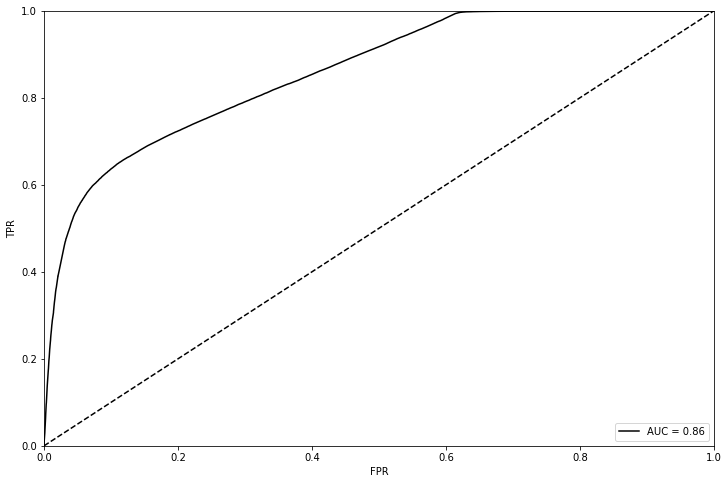

KstestResult(statistic=0.9999693157410249, pvalue=0.0)


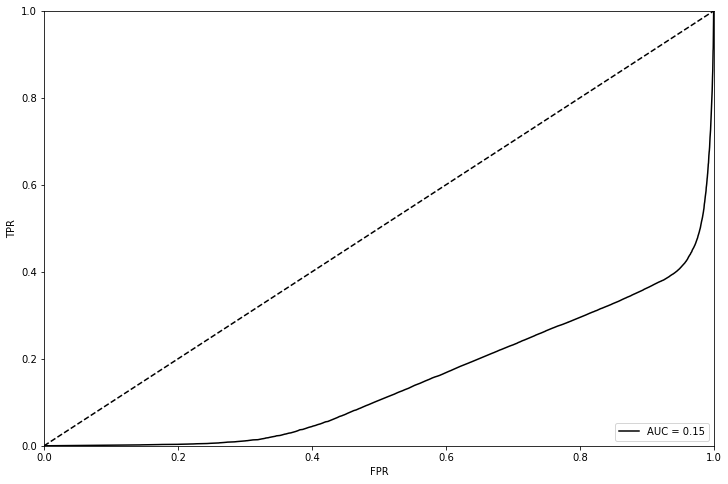

KstestResult(statistic=0.9999691919036323, pvalue=0.0)


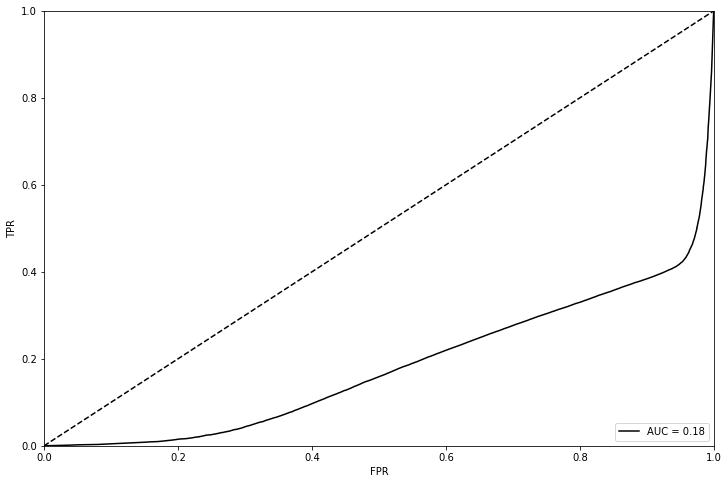

KstestResult(statistic=0.9999690919206281, pvalue=0.0)


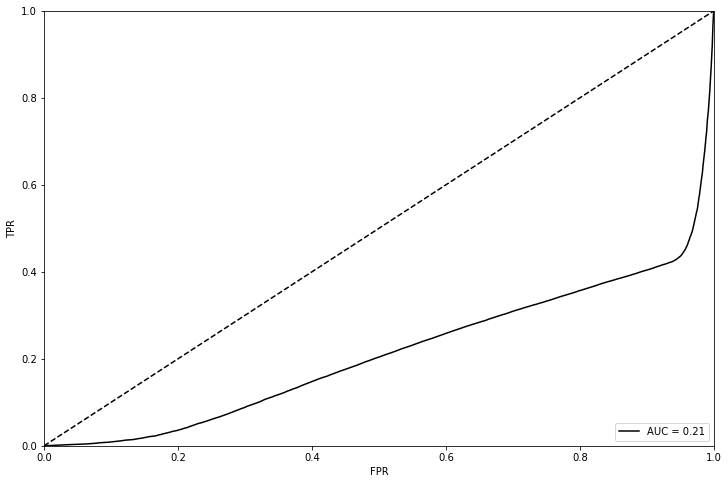

KstestResult(statistic=0.9999689874399131, pvalue=0.0)


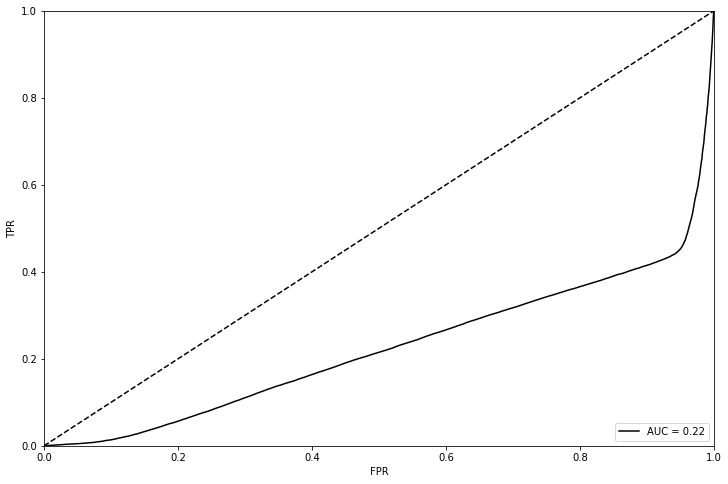

KstestResult(statistic=0.999968869657255, pvalue=0.0)


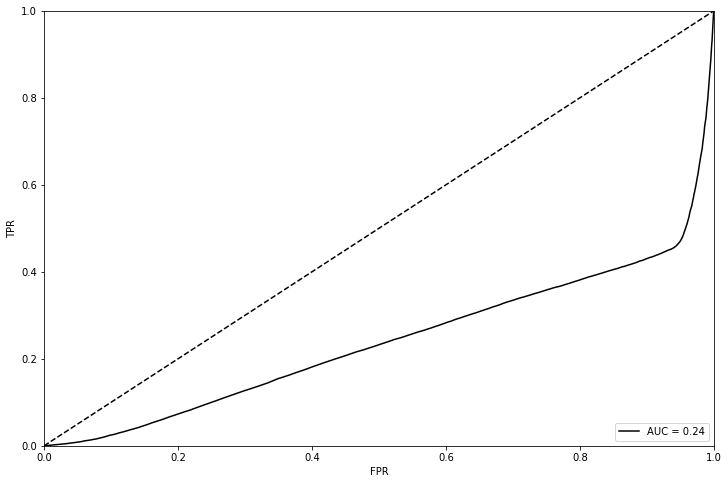

KstestResult(statistic=0.9999687558582766, pvalue=0.0)


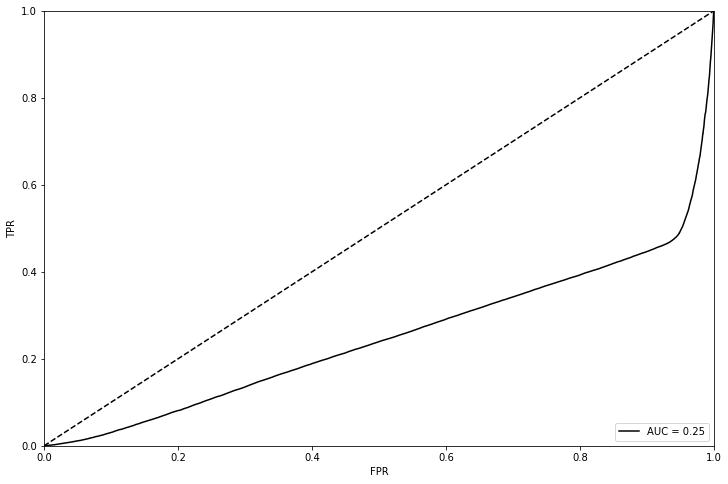

KstestResult(statistic=0.9999686441740876, pvalue=0.0)


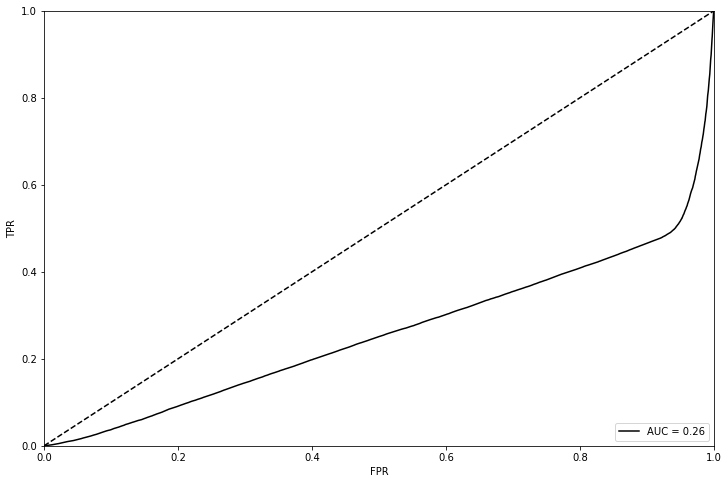

KstestResult(statistic=0.9999685366390838, pvalue=0.0)


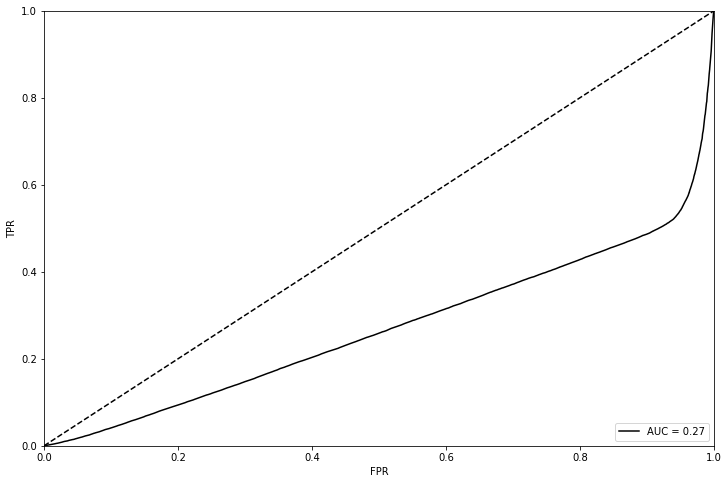

KstestResult(statistic=0.9999684223822155, pvalue=0.0)


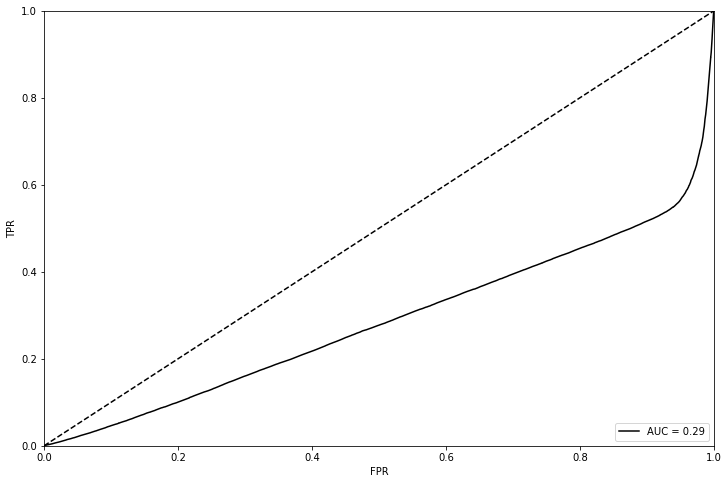

KstestResult(statistic=0.9999683133179125, pvalue=0.0)


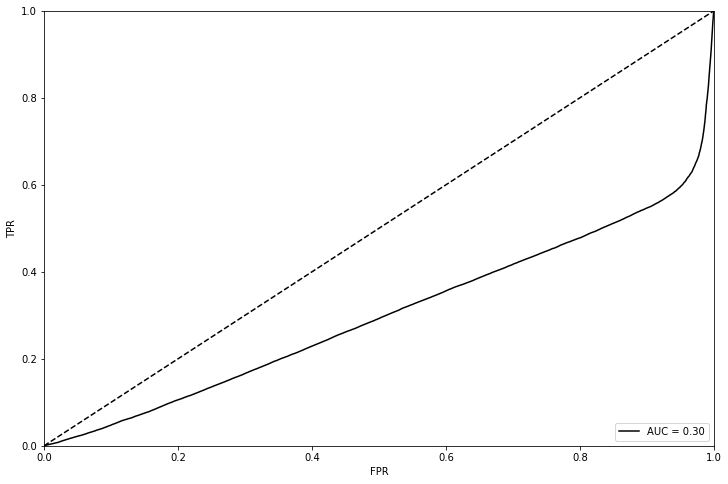

KstestResult(statistic=0.9999681943958525, pvalue=0.0)


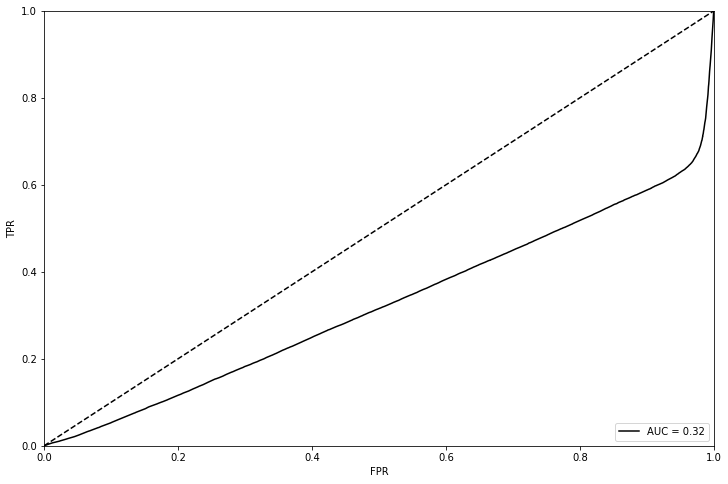

KstestResult(statistic=0.9999680868038934, pvalue=0.0)


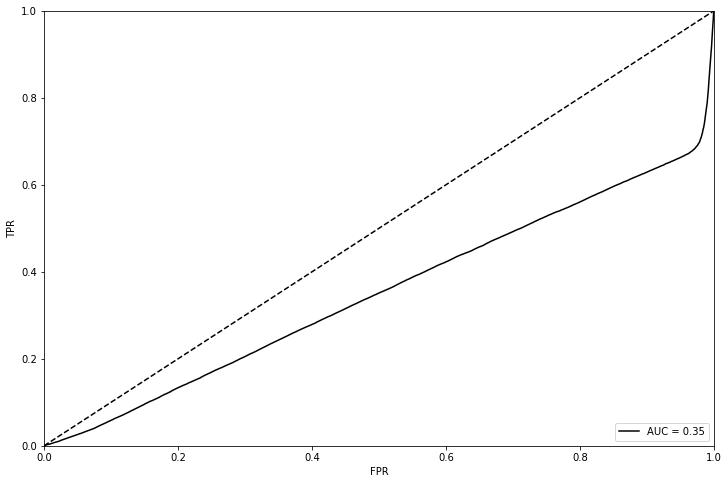

KstestResult(statistic=0.9999679764306529, pvalue=0.0)


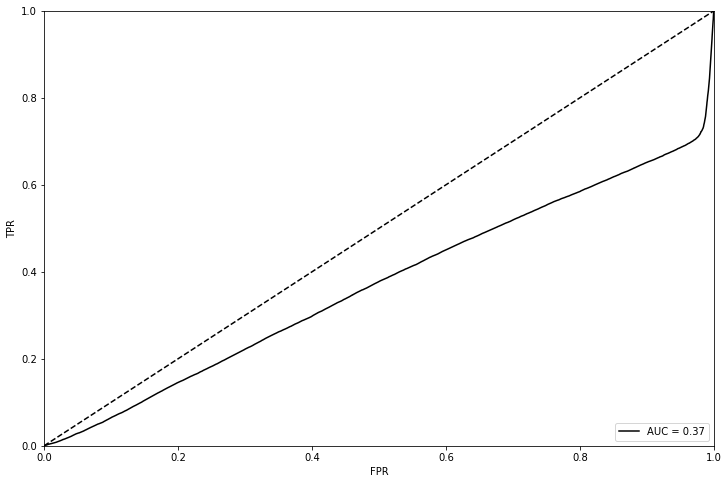

KstestResult(statistic=0.9999678642586285, pvalue=0.0)


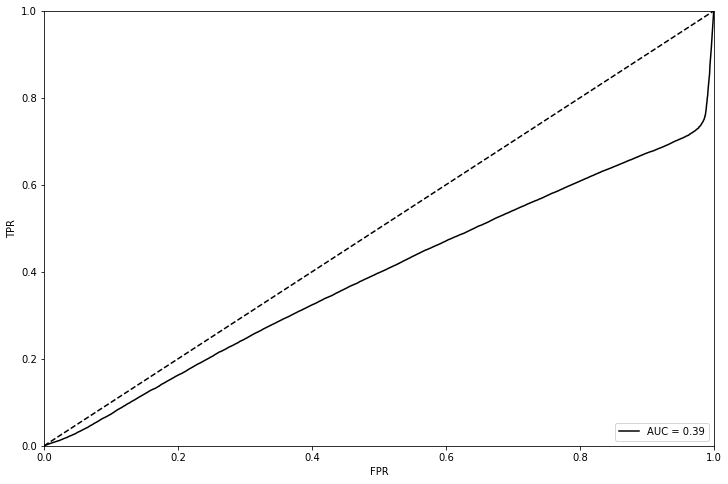

KstestResult(statistic=0.9999677564970658, pvalue=0.0)


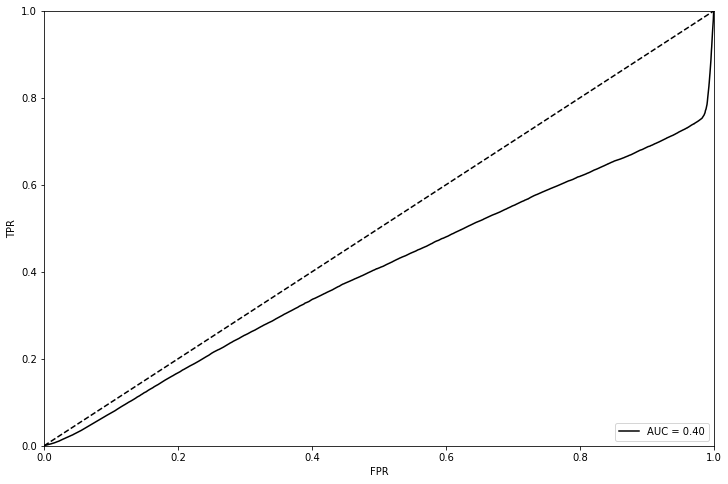

KstestResult(statistic=0.9999676427762498, pvalue=0.0)


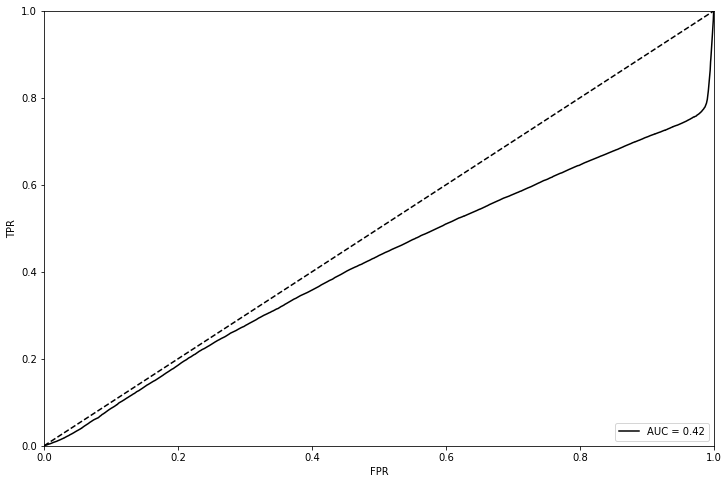

KstestResult(statistic=0.9999675335216389, pvalue=0.0)


In [ ]:
data = pd.concat([rep, non_rep], sort=True)

temperature = 1 # how to find a good temperature value?
n_drop = 100 # number of instances to drop per iteration

while True:
    
    rf = RandomForestClassifier(n_estimators=50, 
                                bootstrap=True,
                                max_features = 'sqrt',
                                oob_score=False)
        
    preds = cross_val_predict(rf, 
                              data.drop(['label', 'Above/Below 50K'], axis=1),
                              data['label'], 
                              cv=10,
                              method='predict_proba')
    
    data['preds'] = [p[0] for p in preds] 
    
    roc(data.label, data.preds, 1, 'name')
    
    if len(data[data.label == 1]['preds']) < n_drop:
        break;
    else:
        for i in range(n_drop):
            softmax = sample(data[data.label == 1]['preds'], temperature)
            drop_id = np.argmax(softmax)
            data.drop(data.index[drop_id], inplace=True)
    
    print(stats.kstest(softmax, 'uniform')) # softmax or preds for kstest?        